# Stock Price Prediction

## In this project, a classification model is used to predict whether we should buy or sell Apple stocks

### Importing libraries, and downloading Apple's historical stock price data

In [1]:
!pip3 install yfinance --upgrade --no-cache-dir --quiet


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [3]:
aapl = yf.download("AAPL", start="2015-01-01", end="2023-08-31")

[*********************100%%**********************]  1 of 1 completed


### Exploring the data

In [4]:
type(aapl)

pandas.core.frame.DataFrame

In [5]:
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.435272,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.746893,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.749121,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.082140,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.007431,237458000


In [6]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2180 entries, 2015-01-02 to 2023-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2180 non-null   float64
 1   High       2180 non-null   float64
 2   Low        2180 non-null   float64
 3   Close      2180 non-null   float64
 4   Adj Close  2180 non-null   float64
 5   Volume     2180 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 119.2 KB


There are no missing values.

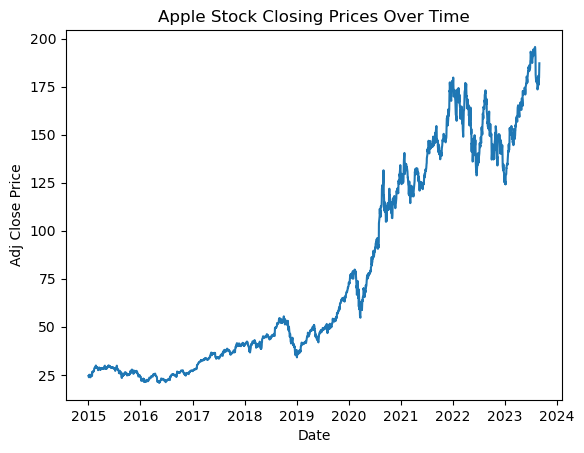

In [7]:
plt.plot(aapl.index, aapl['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('Apple Stock Closing Prices Over Time');

### Strategy 1 

#### If the next trading day's close price is greater than today's close price then the signal is ‘buy’, otherwise ‘sell’

In [8]:
aapl = aapl.drop('Volume', axis=1)

In [9]:
y1 = np.where(aapl['Adj Close'].shift(-1) > aapl['Adj Close'], 1, -1)

In [10]:
type(y1)

numpy.ndarray

### Building and training a KNN model 

In [11]:
trainX, testX, trainy1, testy1 = train_test_split(aapl, y1, test_size=0.2, random_state=42)

In [12]:
# Sanity check

for i in [trainX, testX, trainy1, testy1]:
    print(i.shape)

(1744, 5)
(436, 5)
(1744,)
(436,)


In [13]:
knn1 = KNeighborsClassifier()
knn1.fit(trainX, trainy1)

KNeighborsClassifier()

In [14]:
accuracy_score(testy1, knn1.predict(testX), normalize=True)

0.5

The accuracy is not great. We will see how other models fare

In [15]:
rfc1 = RandomForestClassifier()
rfc1.fit(trainX, trainy1)

RandomForestClassifier()

In [16]:
gbc1 = GradientBoostingClassifier()
gbc1.fit(trainX, trainy1)

GradientBoostingClassifier()

In [17]:
svc1 = SVC()
svc1.fit(trainX, trainy1)

SVC()

XGBoost expects the labels to be 0 or 1

In [18]:
# XGBoost expects the labels to be 0 or 1
xtrainy1 = np.where(trainy1 == -1, 0, trainy1)
xtesty1 = np.where(testy1 == -1, 0, testy1)

In [19]:
xgb1 = XGBClassifier()
xgb1.fit(trainX, xtrainy1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
for model in (knn1, rfc1, gbc1, svc1):
    print(f'Model: {model.__class__.__name__:<30}, accuracy: {accuracy_score(testy1, model.predict(testX), normalize=True)}')
print(f'Model: {xgb1.__class__.__name__:<30}, accuracy: {accuracy_score(xtesty1, model.predict(testX), normalize=True):.5f}')

Model: KNeighborsClassifier          , accuracy: 0.5
Model: RandomForestClassifier        , accuracy: 0.5
Model: GradientBoostingClassifier    , accuracy: 0.5
Model: SVC                           , accuracy: 0.4954128440366973
Model: XGBClassifier                 , accuracy: 0.44495


Stock prices are inherently unpredictable, so an accuracy of about 50% seems right using such a simple strategy

### Strategy 2

#### 50-day moving average vs 200-day moving average

In [21]:
aapl2 = aapl.copy()

aapl2['50_MA'] = aapl2['Close'].rolling(window=50).mean()
aapl2['200_MA'] = aapl2['Close'].rolling(window=200).mean()

two = '''np.where(aapl2['50_MA'] > aapl2['200_MA'], 1, -1)'''
y2 = np.where(aapl2['50_MA'] > aapl2['200_MA'], 1, -1)

In [22]:
aapl2.head()

,Open,High,Low,Close,Adj Close,50_MA,200_MA
Date,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.435272,NaN,NaN
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.746893,NaN,NaN
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.749121,NaN,NaN
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.082140,NaN,NaN
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.007431,NaN,NaN


In [23]:
aapl2.loc[:, ['50_MA', '200_MA']].isna().sum()

50_MA      49
200_MA    199
dtype: int64

In [24]:
aapl2 = aapl2.iloc[199:]
y2 = y2[199:]

In [25]:
aapl2.loc[:, ['50_MA', '200_MA']].isna().sum()

50_MA     0
200_MA    0
dtype: int64

In [26]:
aapl2.shape, y2.shape

((1981, 7), (1981,))

In [27]:
trainX2, testX2, trainy2, testy2 = train_test_split(aapl2, y2, test_size=0.2, random_state=42)

In [28]:
knn2 = KNeighborsClassifier()
knn2.fit(trainX2, trainy2)

KNeighborsClassifier()

In [29]:
rfc2 = RandomForestClassifier() 
rfc2.fit(trainX2, trainy2)

RandomForestClassifier()

In [30]:
gbc2 = GradientBoostingClassifier()
gbc2.fit(trainX2, trainy2)

GradientBoostingClassifier()

In [31]:
svc2 = SVC()
svc2.fit(trainX2, trainy2)

SVC()

In [32]:
xtrainy2 = np.where(trainy2 == -1, 0, trainy2)
xtesty2 = np.where(testy2 == -1, 0, testy2)

xgb2 = XGBClassifier()
xgb2.fit(trainX2, xtrainy2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
for model in (knn2, rfc2, gbc2, svc2):
    print(f'Model: {model.__class__.__name__:<30}, accuracy: {accuracy_score(testy2, model.predict(testX2), normalize=True)}')
print(f'Model: {xgb1.__class__.__name__:<30}, accuracy: {accuracy_score(xtesty2, model.predict(testX2), normalize=True):.5f}')

Model: KNeighborsClassifier          , accuracy: 0.9899244332493703
Model: RandomForestClassifier        , accuracy: 0.9924433249370277
Model: GradientBoostingClassifier    , accuracy: 0.9949622166246851
Model: SVC                           , accuracy: 0.889168765743073
Model: XGBClassifier                 , accuracy: 0.68766


Such a high accuracy, does this mean we can use this model to get rich!? <br>
not so fast...let's analyze the strategy we used and what the prediction actually means <br> <br>
The model is basically predicting what we have trained it on...and that is, whether tomorrows 50-day moving average will be greater than tomorrows 200-day moving average. <br>
So basically, whether the stock is going to continue its upwards(or downawards) trend. 

#### Actually predicting the stock price based on our new strategy

First let's just check what the true accuracy of our "new" model is

In [34]:
df = aapl.copy()
df['50_MA'] = df['Close'].rolling(window=50).mean()
df['200_MA'] = df['Close'].rolling(window=200).mean()

df['target'] = np.where(df['50_MA'] > df['200_MA'], 1, -1)

In [35]:
df = df.iloc[199:]

In [36]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [37]:
train_X, train_y = train.drop('target', axis=1), train.target
test_X = test.drop('target', axis=1)
test_y = np.where(test['Adj Close'].shift(-1) > test['Adj Close'], 1, -1)

In [38]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1584, 7), (1584,), (397, 7), (397,))

In [39]:
new_model = RandomForestClassifier()
new_model.fit(train_X, train_y)

RandomForestClassifier()

In [40]:
accuracy_score(new_model.predict(test_X), test_y)

0.4156171284634761

An abysmal 41.6%. <br>
I think, based on the way our model was trained, we can get similar results without using machine learning.

In [41]:
my_preds = np.where(test_X['50_MA'] > test_X['200_MA'], 1, -1)

In [42]:
accuracy_score(my_preds, test_y)

0.41309823677581864

However, remember, the model was trained on a different set of output labels. <br>
Let's try training it on proper output labels

In [43]:
df2 = aapl.copy()
df2['50_MA'] = df2['Close'].rolling(window=50).mean()
df2['200_MA'] = df2['Close'].rolling(window=200).mean()

df2['target'] = np.where(aapl['Adj Close'].shift(-1) > aapl['Adj Close'], 1, -1)

In [44]:
df2 = df2.iloc[199:]

In [45]:
train, test = train_test_split(df2, test_size=0.2, random_state=42)

In [46]:
train_X, train_y = train.drop('target', axis=1), train.target
test_X, test_y = test.drop('target', axis=1), test.target
xyz = np.where(test['Adj Close'].shift(-1) > test['Adj Close'], 1, -1)

In [47]:
new_model = RandomForestClassifier()
new_model.fit(train_X, train_y)

RandomForestClassifier()

In [48]:
accuracy_score(new_model.predict(test_X), xyz)

0.4534005037783375

#### Stock prices are inherently unpredictable, atleast in the short term. <br>
#### A curious thhing to note is that the lowers accuracy we got was 41.3%, so if we just flip the labels of out predictions, our accuracy would be 58.7%. However, this result could be attributed to chance, or it could even mean that we have actually found a pattern (probably accentuated by random chance), atleast for the time period which our data belongs to. Further tests can be done on unseen data